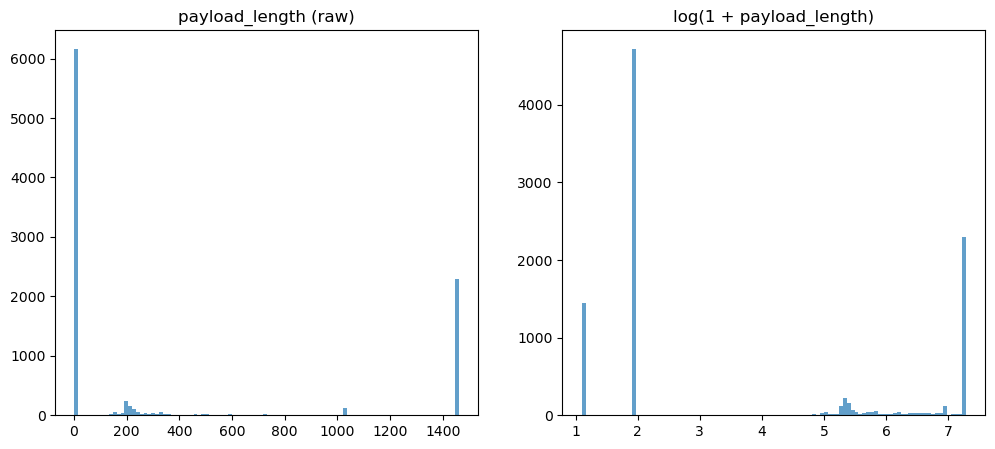

df_raw_HTTP.csv - payload_length
  Raw: NLL=18768.45, KS=0.314
  Log: NLL=-364.94, KS=0.296
  Log (back-transformed): NLL=61164.87, KS=0.296


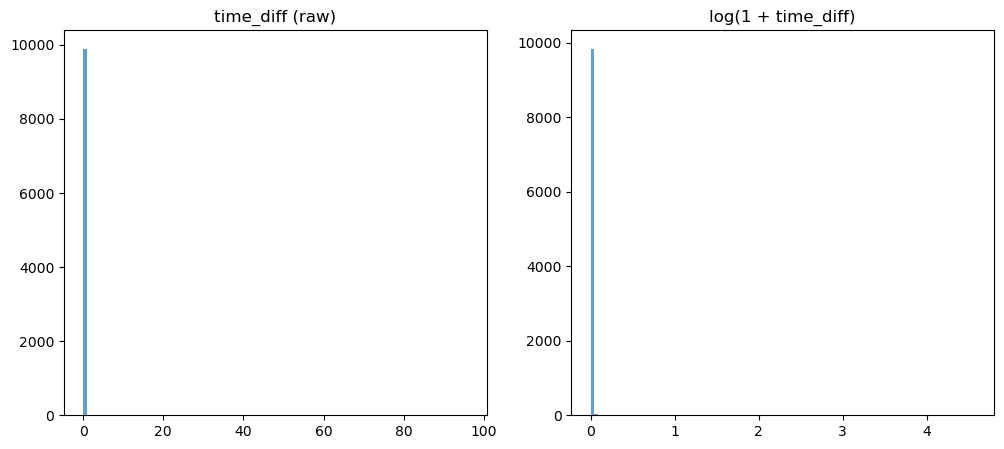

df_raw_HTTP.csv - time_diff
  Raw: NLL=-44253.52, KS=0.158
  Log: NLL=-44723.86, KS=0.157
  Log (back-transformed): NLL=-42445.84, KS=0.157


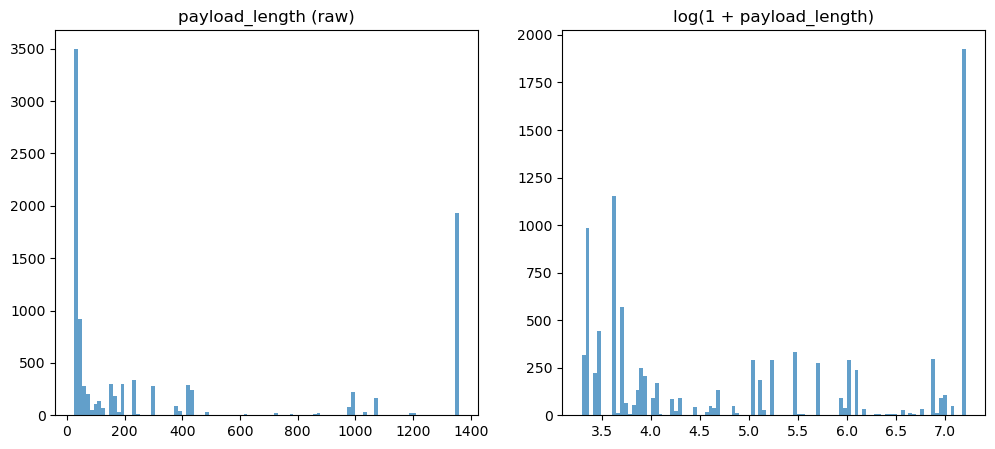

df_raw_UDP_GOOGLE_HOME.csv - payload_length
  Raw: NLL=60938.20, KS=0.118
  Log: NLL=10566.82, KS=0.116
  Log (back-transformed): NLL=61144.43, KS=0.116


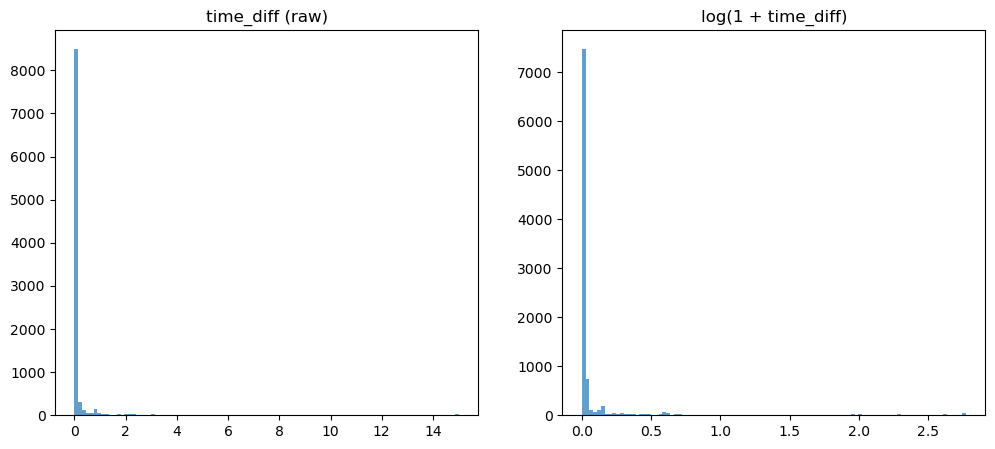

df_raw_UDP_GOOGLE_HOME.csv - time_diff
  Raw: NLL=-22593.13, KS=0.246
  Log: NLL=-24944.57, KS=0.230
  Log (back-transformed): NLL=-21851.13, KS=0.230


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import ks_2samp

def analyze_distribution(file_path, feature, n_components=3):
    df = pd.read_csv(file_path)
    data = df[feature].dropna().values.reshape(-1, 1)
    data_log = np.log1p(data)

    # Plot histograms
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=100, alpha=0.7)
    plt.title(f'{feature} (raw)')
    plt.subplot(1, 2, 2)
    plt.hist(data_log, bins=100, alpha=0.7)
    plt.title(f'log(1 + {feature})')
    plt.show()

    # Fit GMMs
    gmm_raw = GaussianMixture(n_components=n_components, random_state=0).fit(data)
    gmm_log = GaussianMixture(n_components=n_components, random_state=0).fit(data_log)

    # Compute negative log-likelihood
    nll_raw = -gmm_raw.score(data) * len(data)
    nll_log = -gmm_log.score(data_log) * len(data_log)

    # KS statistic (fit sample vs. data)
    sample_raw = gmm_raw.sample(len(data))[0]
    sample_log = gmm_log.sample(len(data_log))[0]
    ks_raw = ks_2samp(data.flatten(), sample_raw.flatten()).statistic
    ks_log = ks_2samp(data_log.flatten(), sample_log.flatten()).statistic

    # --- after fitting the log-space model ---
    sample_log_raw = np.expm1(sample_log)        # back to original units
    ks_log_raw = ks_2samp(data.flatten(), sample_log_raw.flatten()).statistic

    # log-likelihood of the back-transformed sample under the *raw* model
    nll_log_in_raw = -gmm_raw.score(sample_log_raw) * len(sample_log_raw)

    print(f"{file_path} - {feature}")
    print(f"  Raw: NLL={nll_raw:.2f}, KS={ks_raw:.3f}")
    print(f"  Log: NLL={nll_log:.2f}, KS={ks_log:.3f}")
    print(f"  Log (back-transformed): NLL={nll_log_in_raw:.2f}, KS={ks_log_raw:.3f}")

# Analyze both datasets and both features
for file in ['df_raw_HTTP.csv', 'df_raw_UDP_GOOGLE_HOME.csv']:
    for feature in ['payload_length', 'time_diff']:
        analyze_distribution(file, feature)

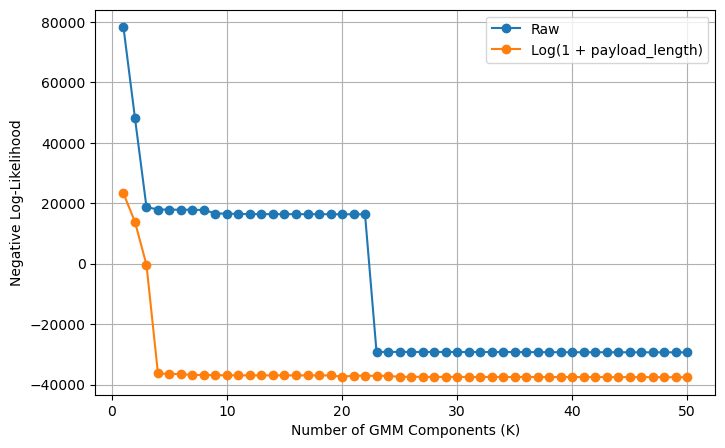

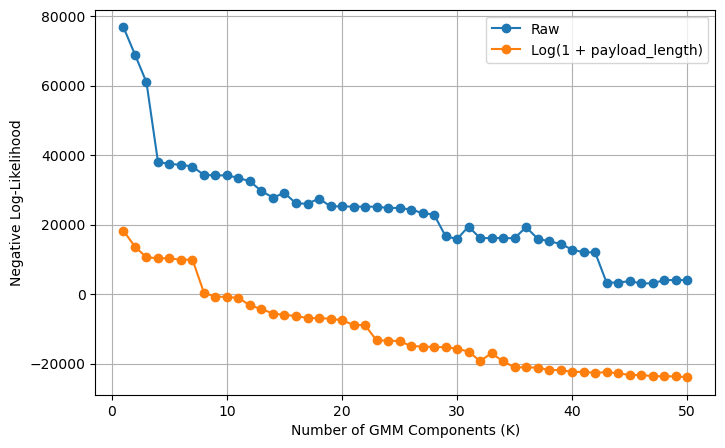

In [6]:
## GMM Component Sweep: Raw vs Log-Transformed Payload Length

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def sweep_gmm_components(file_path, feature, max_components=10):
    df = pd.read_csv(file_path)
    data = df[feature].dropna().values.reshape(-1, 1)
    data_log = np.log1p(data)

    nlls_raw = []
    nlls_log = []
    Ks = range(1, max_components + 1)
    for K in Ks:
        gmm_raw = GaussianMixture(n_components=K, random_state=0).fit(data)
        gmm_log = GaussianMixture(n_components=K, random_state=0).fit(data_log)
        nlls_raw.append(-gmm_raw.score(data) * len(data))
        nlls_log.append(-gmm_log.score(data_log) * len(data_log))

    plt.figure(figsize=(8, 5))
    plt.plot(Ks, nlls_raw, marker='o', label='Raw')
    plt.plot(Ks, nlls_log, marker='o', label='Log(1 + payload_length)')
    plt.xlabel('Number of GMM Components (K)')
    plt.ylabel('Negative Log-Likelihood')
    #plt.title(f'GMM NLL vs K for {feature} in {file_path}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return nlls_raw, nlls_log

# Run the sweep for both datasets
for file in ['df_raw_HTTP.csv', 'df_raw_UDP_GOOGLE_HOME.csv']:
    nlls_raw, nlls_log = sweep_gmm_components(file, 'payload_length', max_components=50)
    # Save plots to CSV for later use in pgfplots or manual import
    payload_df = pd.DataFrame({
        'K':       range(1, len(nlls_raw) + 1),
        'raw':     nlls_raw,
        'log':     nlls_log,
    })
    # save for pgfplots or manual import:
    payload_df.to_csv(f'nll_comp_{file}', index=False)
